# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

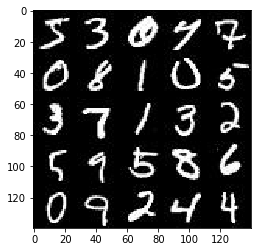

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

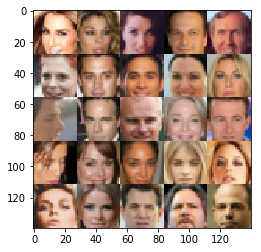

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real=tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),'inputs_real')
    inputs_z=tf.placeholder(tf.float32,(None,z_dim),'inputs_zdim')
    learn_rate=tf.placeholder(tf.float32)
    return (inputs_real,inputs_z,learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope("discriminator",reuse=reuse):
        #image is now 14x14x64
        conv1=tf.layers.conv2d(images,64,5,strides=2,padding='SAME')
        relu1=tf.maximum(conv1*alpha,conv1)
        #7x7x128
        conv2=tf.layers.conv2d(relu1,128,5,strides=2,padding='SAME')
        bn2=tf.layers.batch_normalization(conv2,training=True)
        relu2=tf.maximum(bn2*alpha,bn2)
        #4x4x256
        conv3=tf.layers.conv2d(relu2, 256, 5, strides=2,padding='SAME')
        bn3=tf.layers.batch_normalization(conv3,training=True)
        relu3=tf.maximum(bn3*alpha,bn3)
        #2x2x512
        conv4=tf.layers.conv2d(relu3, 512, 5, strides=2,padding='SAME')
        bn4=tf.layers.batch_normalization(conv4,training=True)
        relu4=tf.maximum(bn4*alpha,bn4)
        
        relu4shape=relu4.get_shape().as_list()
        fullyconnected=tf.reshape(relu4,(-1,relu4shape[1]*relu4shape[2]*relu4shape[3]))
        logits=tf.layers.dense(fullyconnected,1)
        out=tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    
    if is_train==True:
        reuse=False
    else:
        reuse=True
    
    with tf.variable_scope("generator",reuse=reuse):
        fully_connected1=tf.layers.dense(z,7*7*1024)
        
        # 7x7x1024
        reshape1=tf.reshape(fully_connected1,(-1,7,7,1024))
        bn1=tf.layers.batch_normalization(reshape1,training=is_train)
        relu1=tf.maximum(alpha*bn1,bn1)
        # 14x14x512
        conv2=tf.layers.conv2d_transpose(relu1,512,5,strides=2,padding='SAME')
        bn2=tf.layers.batch_normalization(conv2,training=is_train)
        relu2=tf.maximum(alpha*bn2,bn2)
        #14x14x256
        conv3=tf.layers.conv2d_transpose(relu2,256,5,strides=1,padding='SAME')
        bn3=tf.layers.batch_normalization(conv3,training=is_train)
        relu3=tf.maximum(alpha*bn3,bn3)
        #14x14x128
        conv4=tf.layers.conv2d_transpose(relu3,128,5,strides=1,padding='SAME')
        bn4=tf.layers.batch_normalization(conv4,training=is_train)
        relu4=tf.maximum(alpha*bn4,bn4)
        #output is 28x28xout_channel_dim
        logits=tf.layers.conv2d_transpose(relu4,out_channel_dim,5,strides=2,padding='SAME')
        output=tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    fakeimages=generator(input_z,out_channel_dim=out_channel_dim)
    
    output_real,logits_real=discriminator(input_real)
    output_fake,logits_fake=discriminator(fakeimages,reuse=True)
    
    d_loss_real=tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real,labels=tf.ones_like(logits_real)))
    d_loss_fake=tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,labels=tf.zeros_like(logits_fake)))
    g_loss=tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,labels=tf.ones_like(logits_fake)))
    d_loss=d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    variables=tf.trainable_variables()
    d_vars=[var for var in variables if var.name[:3]=='dis']
    g_vars=[var for var in variables if var.name[:3]=='gen']
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt=tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt=tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
        return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real,inputs_z,learn_rate=model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss,g_loss=model_loss(inputs_real, inputs_z, data_shape[3])
    d_opt,g_opt=model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        steps=0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run((g_opt,d_opt),feed_dict={inputs_real:batch_images,inputs_z:batch_z})
                
                
                disc_loss,gen_loss=sess.run([d_loss,g_loss],feed_dict={inputs_real:batch_images,inputs_z:batch_z})

                
                if steps%10==0:
                    print("Epoch: ",epoch_i,"Batch: ",steps,"Discriminator_Loss: ",disc_loss,"Generator_Loss: ",gen_loss)
                if steps%100==0:
                    show_generator_output(sess, 30, inputs_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch:  0 Batch:  10 Discriminator_Loss:  0.0917578 Generator_Loss:  3.32171
Epoch:  0 Batch:  20 Discriminator_Loss:  0.0635079 Generator_Loss:  3.25861
Epoch:  0 Batch:  30 Discriminator_Loss:  0.912246 Generator_Loss:  1.41444
Epoch:  0 Batch:  40 Discriminator_Loss:  0.584119 Generator_Loss:  1.28997
Epoch:  0 Batch:  50 Discriminator_Loss:  0.0593272 Generator_Loss:  7.08948
Epoch:  0 Batch:  60 Discriminator_Loss:  1.23811 Generator_Loss:  0.835965
Epoch:  0 Batch:  70 Discriminator_Loss:  0.748079 Generator_Loss:  1.72724
Epoch:  0 Batch:  80 Discriminator_Loss:  1.27877 Generator_Loss:  2.60268
Epoch:  0 Batch:  90 Discriminator_Loss:  0.809883 Generator_Loss:  1.82601
Epoch:  0 Batch:  100 Discriminator_Loss:  1.05034 Generator_Loss:  1.47082


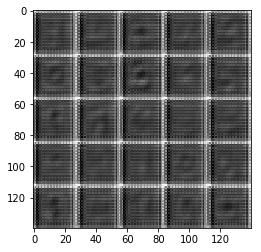

Epoch:  0 Batch:  110 Discriminator_Loss:  1.78672 Generator_Loss:  0.267076
Epoch:  0 Batch:  120 Discriminator_Loss:  1.14687 Generator_Loss:  2.47338
Epoch:  0 Batch:  130 Discriminator_Loss:  1.35751 Generator_Loss:  0.374662
Epoch:  0 Batch:  140 Discriminator_Loss:  0.995624 Generator_Loss:  0.612695
Epoch:  0 Batch:  150 Discriminator_Loss:  0.158721 Generator_Loss:  3.76999
Epoch:  0 Batch:  160 Discriminator_Loss:  0.754485 Generator_Loss:  1.38719
Epoch:  0 Batch:  170 Discriminator_Loss:  1.41361 Generator_Loss:  5.39413
Epoch:  0 Batch:  180 Discriminator_Loss:  1.01687 Generator_Loss:  0.581592
Epoch:  0 Batch:  190 Discriminator_Loss:  0.413096 Generator_Loss:  1.68426
Epoch:  0 Batch:  200 Discriminator_Loss:  0.548196 Generator_Loss:  1.62292


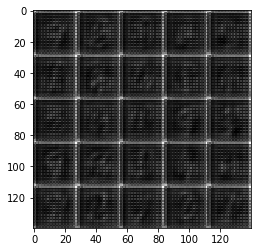

Epoch:  0 Batch:  210 Discriminator_Loss:  0.910786 Generator_Loss:  4.5497
Epoch:  0 Batch:  220 Discriminator_Loss:  0.520773 Generator_Loss:  3.9644
Epoch:  0 Batch:  230 Discriminator_Loss:  0.363748 Generator_Loss:  3.80899
Epoch:  0 Batch:  240 Discriminator_Loss:  0.142044 Generator_Loss:  2.8111
Epoch:  0 Batch:  250 Discriminator_Loss:  0.358442 Generator_Loss:  1.42495
Epoch:  0 Batch:  260 Discriminator_Loss:  1.81484 Generator_Loss:  0.360114
Epoch:  0 Batch:  270 Discriminator_Loss:  0.341775 Generator_Loss:  2.50408
Epoch:  0 Batch:  280 Discriminator_Loss:  0.410409 Generator_Loss:  1.65458
Epoch:  0 Batch:  290 Discriminator_Loss:  0.268042 Generator_Loss:  2.44856
Epoch:  0 Batch:  300 Discriminator_Loss:  0.78769 Generator_Loss:  0.754616


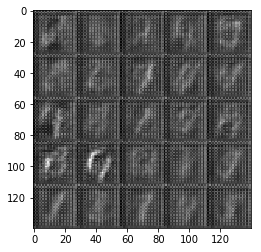

Epoch:  0 Batch:  310 Discriminator_Loss:  0.71335 Generator_Loss:  2.5955
Epoch:  0 Batch:  320 Discriminator_Loss:  0.578869 Generator_Loss:  3.2596
Epoch:  0 Batch:  330 Discriminator_Loss:  0.110701 Generator_Loss:  5.60862
Epoch:  0 Batch:  340 Discriminator_Loss:  0.489932 Generator_Loss:  2.38125
Epoch:  0 Batch:  350 Discriminator_Loss:  0.537881 Generator_Loss:  5.75649
Epoch:  0 Batch:  360 Discriminator_Loss:  0.208115 Generator_Loss:  2.10462
Epoch:  0 Batch:  370 Discriminator_Loss:  0.278385 Generator_Loss:  5.85442
Epoch:  0 Batch:  380 Discriminator_Loss:  0.495057 Generator_Loss:  1.28696
Epoch:  0 Batch:  390 Discriminator_Loss:  1.29895 Generator_Loss:  0.413253
Epoch:  0 Batch:  400 Discriminator_Loss:  0.103735 Generator_Loss:  3.81454


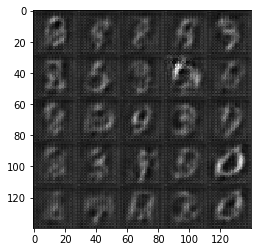

Epoch:  0 Batch:  410 Discriminator_Loss:  0.898004 Generator_Loss:  0.647027
Epoch:  0 Batch:  420 Discriminator_Loss:  0.121696 Generator_Loss:  3.58829
Epoch:  0 Batch:  430 Discriminator_Loss:  1.07606 Generator_Loss:  6.50591
Epoch:  0 Batch:  440 Discriminator_Loss:  0.341682 Generator_Loss:  1.46536
Epoch:  0 Batch:  450 Discriminator_Loss:  0.292525 Generator_Loss:  1.66654
Epoch:  0 Batch:  460 Discriminator_Loss:  0.0653551 Generator_Loss:  4.59419
Epoch:  1 Batch:  470 Discriminator_Loss:  0.0441195 Generator_Loss:  6.11035
Epoch:  1 Batch:  480 Discriminator_Loss:  0.0472501 Generator_Loss:  4.59713
Epoch:  1 Batch:  490 Discriminator_Loss:  5.05355 Generator_Loss:  7.6719
Epoch:  1 Batch:  500 Discriminator_Loss:  1.2465 Generator_Loss:  0.499228


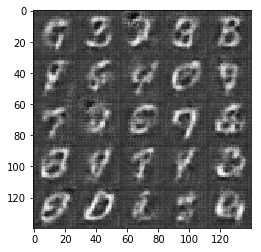

Epoch:  1 Batch:  510 Discriminator_Loss:  0.868354 Generator_Loss:  0.675443
Epoch:  1 Batch:  520 Discriminator_Loss:  0.10977 Generator_Loss:  4.04166
Epoch:  1 Batch:  530 Discriminator_Loss:  0.542363 Generator_Loss:  1.16383
Epoch:  1 Batch:  540 Discriminator_Loss:  0.352494 Generator_Loss:  1.54021
Epoch:  1 Batch:  550 Discriminator_Loss:  0.280957 Generator_Loss:  2.85621
Epoch:  1 Batch:  560 Discriminator_Loss:  0.0539241 Generator_Loss:  4.67793
Epoch:  1 Batch:  570 Discriminator_Loss:  0.0303603 Generator_Loss:  6.84357
Epoch:  1 Batch:  580 Discriminator_Loss:  0.473122 Generator_Loss:  1.1241
Epoch:  1 Batch:  590 Discriminator_Loss:  0.758145 Generator_Loss:  0.879762
Epoch:  1 Batch:  600 Discriminator_Loss:  0.177603 Generator_Loss:  2.26942


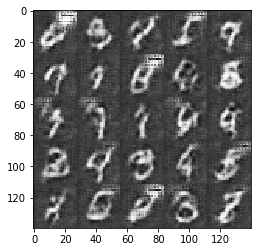

Epoch:  1 Batch:  610 Discriminator_Loss:  0.0853158 Generator_Loss:  3.33004
Epoch:  1 Batch:  620 Discriminator_Loss:  2.63283 Generator_Loss:  0.121811
Epoch:  1 Batch:  630 Discriminator_Loss:  0.29283 Generator_Loss:  1.96281
Epoch:  1 Batch:  640 Discriminator_Loss:  0.0584062 Generator_Loss:  5.99553
Epoch:  1 Batch:  650 Discriminator_Loss:  1.14528 Generator_Loss:  1.30356
Epoch:  1 Batch:  660 Discriminator_Loss:  0.829168 Generator_Loss:  6.49035
Epoch:  1 Batch:  670 Discriminator_Loss:  0.991396 Generator_Loss:  4.66332
Epoch:  1 Batch:  680 Discriminator_Loss:  0.183414 Generator_Loss:  2.22354
Epoch:  1 Batch:  690 Discriminator_Loss:  0.0450571 Generator_Loss:  4.94689
Epoch:  1 Batch:  700 Discriminator_Loss:  0.0561914 Generator_Loss:  3.68935


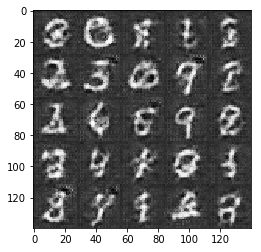

Epoch:  1 Batch:  710 Discriminator_Loss:  0.240731 Generator_Loss:  2.07763
Epoch:  1 Batch:  720 Discriminator_Loss:  0.118455 Generator_Loss:  2.77045
Epoch:  1 Batch:  730 Discriminator_Loss:  0.262995 Generator_Loss:  1.77971
Epoch:  1 Batch:  740 Discriminator_Loss:  0.689263 Generator_Loss:  7.25562
Epoch:  1 Batch:  750 Discriminator_Loss:  1.04509 Generator_Loss:  0.596641
Epoch:  1 Batch:  760 Discriminator_Loss:  1.28176 Generator_Loss:  0.409638
Epoch:  1 Batch:  770 Discriminator_Loss:  0.249678 Generator_Loss:  5.16621
Epoch:  1 Batch:  780 Discriminator_Loss:  0.0242293 Generator_Loss:  6.88743
Epoch:  1 Batch:  790 Discriminator_Loss:  0.0295321 Generator_Loss:  7.39274
Epoch:  1 Batch:  800 Discriminator_Loss:  0.0420294 Generator_Loss:  5.73549


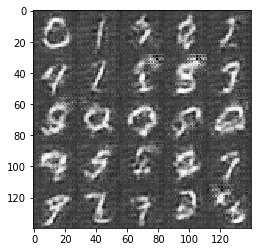

Epoch:  1 Batch:  810 Discriminator_Loss:  0.0501156 Generator_Loss:  5.45511
Epoch:  1 Batch:  820 Discriminator_Loss:  0.0972235 Generator_Loss:  3.00208
Epoch:  1 Batch:  830 Discriminator_Loss:  0.0708301 Generator_Loss:  9.90106
Epoch:  1 Batch:  840 Discriminator_Loss:  0.898308 Generator_Loss:  0.701911
Epoch:  1 Batch:  850 Discriminator_Loss:  0.649927 Generator_Loss:  2.54999
Epoch:  1 Batch:  860 Discriminator_Loss:  0.219531 Generator_Loss:  2.8261
Epoch:  1 Batch:  870 Discriminator_Loss:  0.424315 Generator_Loss:  1.3333
Epoch:  1 Batch:  880 Discriminator_Loss:  0.822086 Generator_Loss:  0.664168
Epoch:  1 Batch:  890 Discriminator_Loss:  0.163194 Generator_Loss:  3.85953
Epoch:  1 Batch:  900 Discriminator_Loss:  0.197279 Generator_Loss:  2.93802


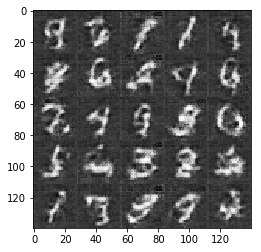

Epoch:  1 Batch:  910 Discriminator_Loss:  0.303986 Generator_Loss:  2.72629
Epoch:  1 Batch:  920 Discriminator_Loss:  0.285005 Generator_Loss:  1.66065
Epoch:  1 Batch:  930 Discriminator_Loss:  1.379 Generator_Loss:  0.383196


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch:  0 Batch:  10 Discriminator_Loss:  4.42554 Generator_Loss:  7.00714
Epoch:  0 Batch:  20 Discriminator_Loss:  0.382568 Generator_Loss:  1.55307
Epoch:  0 Batch:  30 Discriminator_Loss:  0.529893 Generator_Loss:  2.09265
Epoch:  0 Batch:  40 Discriminator_Loss:  0.772037 Generator_Loss:  1.6784
Epoch:  0 Batch:  50 Discriminator_Loss:  2.13256 Generator_Loss:  3.53697
Epoch:  0 Batch:  60 Discriminator_Loss:  1.8279 Generator_Loss:  2.48966
Epoch:  0 Batch:  70 Discriminator_Loss:  0.909445 Generator_Loss:  1.39369
Epoch:  0 Batch:  80 Discriminator_Loss:  1.06785 Generator_Loss:  3.93706
Epoch:  0 Batch:  90 Discriminator_Loss:  3.35623 Generator_Loss:  5.6093
Epoch:  0 Batch:  100 Discriminator_Loss:  0.287441 Generator_Loss:  1.71237


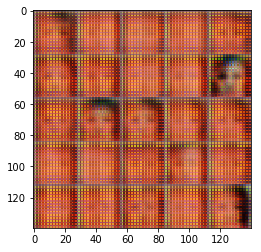

Epoch:  0 Batch:  110 Discriminator_Loss:  0.114639 Generator_Loss:  2.49938
Epoch:  0 Batch:  120 Discriminator_Loss:  1.6357 Generator_Loss:  2.04744
Epoch:  0 Batch:  130 Discriminator_Loss:  1.82717 Generator_Loss:  2.55243
Epoch:  0 Batch:  140 Discriminator_Loss:  0.917456 Generator_Loss:  0.849963
Epoch:  0 Batch:  150 Discriminator_Loss:  1.11995 Generator_Loss:  0.974222
Epoch:  0 Batch:  160 Discriminator_Loss:  0.0592477 Generator_Loss:  3.81465
Epoch:  0 Batch:  170 Discriminator_Loss:  0.453044 Generator_Loss:  1.14374
Epoch:  0 Batch:  180 Discriminator_Loss:  0.0551627 Generator_Loss:  3.14611
Epoch:  0 Batch:  190 Discriminator_Loss:  0.134962 Generator_Loss:  2.17359
Epoch:  0 Batch:  200 Discriminator_Loss:  1.15887 Generator_Loss:  1.02367


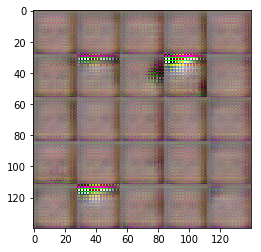

Epoch:  0 Batch:  210 Discriminator_Loss:  2.02777 Generator_Loss:  0.804333
Epoch:  0 Batch:  220 Discriminator_Loss:  1.2337 Generator_Loss:  1.31988
Epoch:  0 Batch:  230 Discriminator_Loss:  0.349631 Generator_Loss:  1.55687
Epoch:  0 Batch:  240 Discriminator_Loss:  1.28849 Generator_Loss:  5.2419
Epoch:  0 Batch:  250 Discriminator_Loss:  3.94635 Generator_Loss:  7.02699
Epoch:  0 Batch:  260 Discriminator_Loss:  1.00611 Generator_Loss:  1.40707
Epoch:  0 Batch:  270 Discriminator_Loss:  0.288733 Generator_Loss:  1.59543
Epoch:  0 Batch:  280 Discriminator_Loss:  0.66947 Generator_Loss:  0.834823
Epoch:  0 Batch:  290 Discriminator_Loss:  0.532674 Generator_Loss:  1.1399
Epoch:  0 Batch:  300 Discriminator_Loss:  2.45359 Generator_Loss:  0.0971663


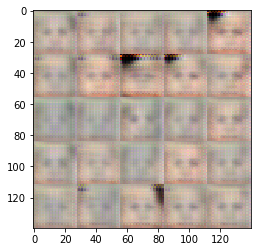

Epoch:  0 Batch:  310 Discriminator_Loss:  0.989476 Generator_Loss:  0.823107
Epoch:  0 Batch:  320 Discriminator_Loss:  0.363105 Generator_Loss:  1.46817
Epoch:  0 Batch:  330 Discriminator_Loss:  0.132335 Generator_Loss:  2.40594
Epoch:  0 Batch:  340 Discriminator_Loss:  0.0838648 Generator_Loss:  2.83196
Epoch:  0 Batch:  350 Discriminator_Loss:  1.35533 Generator_Loss:  6.16461
Epoch:  0 Batch:  360 Discriminator_Loss:  3.31676 Generator_Loss:  5.7904
Epoch:  0 Batch:  370 Discriminator_Loss:  3.59856 Generator_Loss:  5.06082
Epoch:  0 Batch:  380 Discriminator_Loss:  0.876179 Generator_Loss:  3.91202
Epoch:  0 Batch:  390 Discriminator_Loss:  0.283659 Generator_Loss:  1.57487
Epoch:  0 Batch:  400 Discriminator_Loss:  0.178562 Generator_Loss:  2.22931


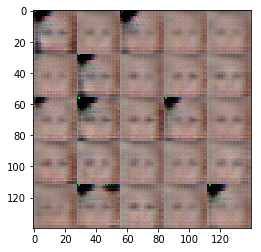

Epoch:  0 Batch:  410 Discriminator_Loss:  0.538102 Generator_Loss:  0.92005
Epoch:  0 Batch:  420 Discriminator_Loss:  0.673219 Generator_Loss:  1.38336
Epoch:  0 Batch:  430 Discriminator_Loss:  0.81281 Generator_Loss:  1.75534
Epoch:  0 Batch:  440 Discriminator_Loss:  0.162897 Generator_Loss:  2.27867
Epoch:  0 Batch:  450 Discriminator_Loss:  0.123513 Generator_Loss:  3.68042
Epoch:  0 Batch:  460 Discriminator_Loss:  0.753018 Generator_Loss:  6.98714
Epoch:  0 Batch:  470 Discriminator_Loss:  0.109599 Generator_Loss:  4.65099
Epoch:  0 Batch:  480 Discriminator_Loss:  0.522072 Generator_Loss:  1.41667
Epoch:  0 Batch:  490 Discriminator_Loss:  0.1481 Generator_Loss:  2.25522
Epoch:  0 Batch:  500 Discriminator_Loss:  0.104842 Generator_Loss:  2.71864


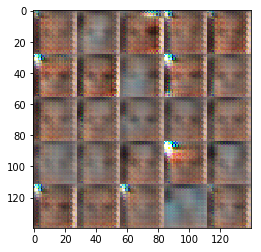

Epoch:  0 Batch:  510 Discriminator_Loss:  0.0278203 Generator_Loss:  4.25914
Epoch:  0 Batch:  520 Discriminator_Loss:  0.0185328 Generator_Loss:  4.3478
Epoch:  0 Batch:  530 Discriminator_Loss:  6.16819 Generator_Loss:  7.21335
Epoch:  0 Batch:  540 Discriminator_Loss:  1.73679 Generator_Loss:  0.894398
Epoch:  0 Batch:  550 Discriminator_Loss:  1.63837 Generator_Loss:  0.742773
Epoch:  0 Batch:  560 Discriminator_Loss:  1.35504 Generator_Loss:  0.711121
Epoch:  0 Batch:  570 Discriminator_Loss:  1.27882 Generator_Loss:  0.80147
Epoch:  0 Batch:  580 Discriminator_Loss:  1.57102 Generator_Loss:  1.40799
Epoch:  0 Batch:  590 Discriminator_Loss:  1.36956 Generator_Loss:  1.05915
Epoch:  0 Batch:  600 Discriminator_Loss:  1.36071 Generator_Loss:  1.12093


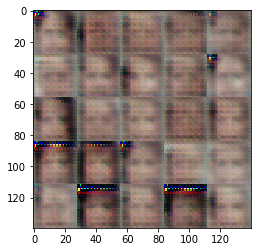

Epoch:  0 Batch:  610 Discriminator_Loss:  0.953132 Generator_Loss:  1.20327
Epoch:  0 Batch:  620 Discriminator_Loss:  1.63236 Generator_Loss:  0.67646
Epoch:  0 Batch:  630 Discriminator_Loss:  1.30898 Generator_Loss:  0.874476
Epoch:  0 Batch:  640 Discriminator_Loss:  1.47931 Generator_Loss:  0.708242
Epoch:  0 Batch:  650 Discriminator_Loss:  1.25857 Generator_Loss:  0.9591
Epoch:  0 Batch:  660 Discriminator_Loss:  1.4769 Generator_Loss:  0.36297
Epoch:  0 Batch:  670 Discriminator_Loss:  1.19772 Generator_Loss:  0.999155
Epoch:  0 Batch:  680 Discriminator_Loss:  1.08518 Generator_Loss:  0.747083
Epoch:  0 Batch:  690 Discriminator_Loss:  0.402283 Generator_Loss:  1.63477
Epoch:  0 Batch:  700 Discriminator_Loss:  1.35079 Generator_Loss:  3.28477


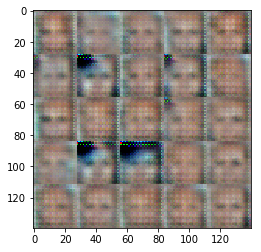

Epoch:  0 Batch:  710 Discriminator_Loss:  1.24926 Generator_Loss:  0.856864
Epoch:  0 Batch:  720 Discriminator_Loss:  1.68628 Generator_Loss:  0.36251
Epoch:  0 Batch:  730 Discriminator_Loss:  1.34017 Generator_Loss:  1.52357
Epoch:  0 Batch:  740 Discriminator_Loss:  0.645152 Generator_Loss:  1.80471
Epoch:  0 Batch:  750 Discriminator_Loss:  0.34196 Generator_Loss:  1.34923
Epoch:  0 Batch:  760 Discriminator_Loss:  1.03737 Generator_Loss:  0.718378
Epoch:  0 Batch:  770 Discriminator_Loss:  2.34323 Generator_Loss:  0.122499
Epoch:  0 Batch:  780 Discriminator_Loss:  0.117546 Generator_Loss:  2.82252
Epoch:  0 Batch:  790 Discriminator_Loss:  0.121901 Generator_Loss:  2.36836
Epoch:  0 Batch:  800 Discriminator_Loss:  0.0442789 Generator_Loss:  3.38644


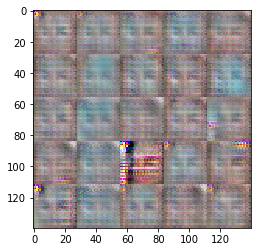

Epoch:  0 Batch:  810 Discriminator_Loss:  0.0673519 Generator_Loss:  3.01723
Epoch:  0 Batch:  820 Discriminator_Loss:  6.94831 Generator_Loss:  6.87485
Epoch:  0 Batch:  830 Discriminator_Loss:  0.0831906 Generator_Loss:  2.77393
Epoch:  0 Batch:  840 Discriminator_Loss:  0.0188302 Generator_Loss:  4.6939
Epoch:  0 Batch:  850 Discriminator_Loss:  0.774253 Generator_Loss:  0.695397
Epoch:  0 Batch:  860 Discriminator_Loss:  0.0936986 Generator_Loss:  2.63518
Epoch:  0 Batch:  870 Discriminator_Loss:  0.0298024 Generator_Loss:  3.85258
Epoch:  0 Batch:  880 Discriminator_Loss:  0.0632783 Generator_Loss:  3.05963
Epoch:  0 Batch:  890 Discriminator_Loss:  0.0140344 Generator_Loss:  4.58263
Epoch:  0 Batch:  900 Discriminator_Loss:  0.0498162 Generator_Loss:  3.18553


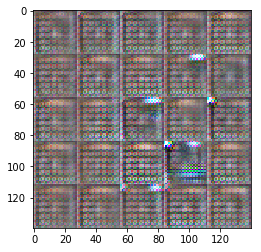

Epoch:  0 Batch:  910 Discriminator_Loss:  0.0337614 Generator_Loss:  3.61382
Epoch:  0 Batch:  920 Discriminator_Loss:  0.0173004 Generator_Loss:  4.37605
Epoch:  0 Batch:  930 Discriminator_Loss:  0.0118891 Generator_Loss:  4.6731
Epoch:  0 Batch:  940 Discriminator_Loss:  0.0125951 Generator_Loss:  4.63307
Epoch:  0 Batch:  950 Discriminator_Loss:  0.00353552 Generator_Loss:  6.39669
Epoch:  0 Batch:  960 Discriminator_Loss:  0.107506 Generator_Loss:  2.4809
Epoch:  0 Batch:  970 Discriminator_Loss:  0.0300747 Generator_Loss:  3.77535
Epoch:  0 Batch:  980 Discriminator_Loss:  0.0157692 Generator_Loss:  4.67455
Epoch:  0 Batch:  990 Discriminator_Loss:  0.501663 Generator_Loss:  1.1671
Epoch:  0 Batch:  1000 Discriminator_Loss:  0.0704444 Generator_Loss:  2.94077


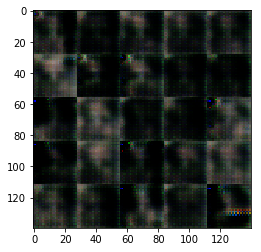

Epoch:  0 Batch:  1010 Discriminator_Loss:  4.25509 Generator_Loss:  5.03364
Epoch:  0 Batch:  1020 Discriminator_Loss:  1.64818 Generator_Loss:  0.314518
Epoch:  0 Batch:  1030 Discriminator_Loss:  1.40365 Generator_Loss:  0.58852
Epoch:  0 Batch:  1040 Discriminator_Loss:  1.09733 Generator_Loss:  1.95889
Epoch:  0 Batch:  1050 Discriminator_Loss:  0.676172 Generator_Loss:  1.14484
Epoch:  0 Batch:  1060 Discriminator_Loss:  0.0908643 Generator_Loss:  2.73174
Epoch:  0 Batch:  1070 Discriminator_Loss:  0.0426652 Generator_Loss:  3.82578
Epoch:  0 Batch:  1080 Discriminator_Loss:  0.0338499 Generator_Loss:  3.9691
Epoch:  0 Batch:  1090 Discriminator_Loss:  0.0161989 Generator_Loss:  4.52369
Epoch:  0 Batch:  1100 Discriminator_Loss:  0.0290962 Generator_Loss:  3.79538


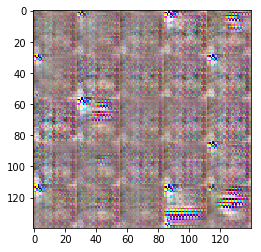

Epoch:  0 Batch:  1110 Discriminator_Loss:  0.0153185 Generator_Loss:  4.57672
Epoch:  0 Batch:  1120 Discriminator_Loss:  0.0286622 Generator_Loss:  3.82682
Epoch:  0 Batch:  1130 Discriminator_Loss:  0.9461 Generator_Loss:  0.915939
Epoch:  0 Batch:  1140 Discriminator_Loss:  0.09567 Generator_Loss:  2.65668
Epoch:  0 Batch:  1150 Discriminator_Loss:  0.0729349 Generator_Loss:  2.9909
Epoch:  0 Batch:  1160 Discriminator_Loss:  0.228372 Generator_Loss:  5.90301
Epoch:  0 Batch:  1170 Discriminator_Loss:  0.756455 Generator_Loss:  0.934518
Epoch:  0 Batch:  1180 Discriminator_Loss:  0.635494 Generator_Loss:  0.940881
Epoch:  0 Batch:  1190 Discriminator_Loss:  0.531913 Generator_Loss:  1.01996
Epoch:  0 Batch:  1200 Discriminator_Loss:  0.184864 Generator_Loss:  1.96889


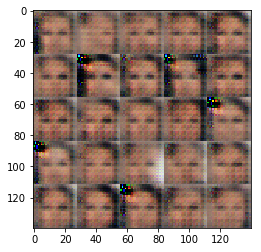

Epoch:  0 Batch:  1210 Discriminator_Loss:  0.176072 Generator_Loss:  2.03302
Epoch:  0 Batch:  1220 Discriminator_Loss:  0.472471 Generator_Loss:  1.1688
Epoch:  0 Batch:  1230 Discriminator_Loss:  0.548415 Generator_Loss:  0.934256
Epoch:  0 Batch:  1240 Discriminator_Loss:  1.38297 Generator_Loss:  0.339756
Epoch:  0 Batch:  1250 Discriminator_Loss:  0.791801 Generator_Loss:  0.665283
Epoch:  0 Batch:  1260 Discriminator_Loss:  0.558858 Generator_Loss:  1.11067
Epoch:  0 Batch:  1270 Discriminator_Loss:  0.792862 Generator_Loss:  1.64837
Epoch:  0 Batch:  1280 Discriminator_Loss:  0.0712324 Generator_Loss:  3.01142
Epoch:  0 Batch:  1290 Discriminator_Loss:  0.0204595 Generator_Loss:  5.8383
Epoch:  0 Batch:  1300 Discriminator_Loss:  0.0343934 Generator_Loss:  3.93466


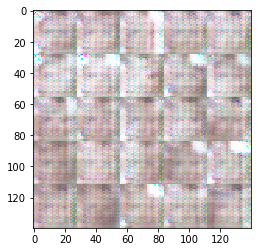

Epoch:  0 Batch:  1310 Discriminator_Loss:  0.246937 Generator_Loss:  2.87035
Epoch:  0 Batch:  1320 Discriminator_Loss:  3.62673 Generator_Loss:  0.0418393
Epoch:  0 Batch:  1330 Discriminator_Loss:  0.745457 Generator_Loss:  1.8995
Epoch:  0 Batch:  1340 Discriminator_Loss:  0.433408 Generator_Loss:  1.18199
Epoch:  0 Batch:  1350 Discriminator_Loss:  0.306637 Generator_Loss:  1.55631
Epoch:  0 Batch:  1360 Discriminator_Loss:  0.076038 Generator_Loss:  3.02522
Epoch:  0 Batch:  1370 Discriminator_Loss:  0.0402374 Generator_Loss:  3.67254
Epoch:  0 Batch:  1380 Discriminator_Loss:  5.04285 Generator_Loss:  6.00124
Epoch:  0 Batch:  1390 Discriminator_Loss:  0.100823 Generator_Loss:  2.86572
Epoch:  0 Batch:  1400 Discriminator_Loss:  3.29559 Generator_Loss:  7.18406


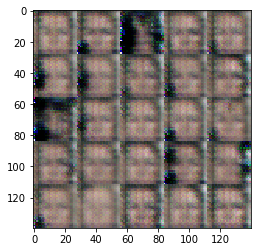

Epoch:  0 Batch:  1410 Discriminator_Loss:  0.511187 Generator_Loss:  1.13986
Epoch:  0 Batch:  1420 Discriminator_Loss:  0.217091 Generator_Loss:  3.34933
Epoch:  0 Batch:  1430 Discriminator_Loss:  1.48573 Generator_Loss:  0.915616
Epoch:  0 Batch:  1440 Discriminator_Loss:  1.5266 Generator_Loss:  1.11986
Epoch:  0 Batch:  1450 Discriminator_Loss:  1.59348 Generator_Loss:  1.90261
Epoch:  0 Batch:  1460 Discriminator_Loss:  1.23569 Generator_Loss:  1.32593
Epoch:  0 Batch:  1470 Discriminator_Loss:  1.19007 Generator_Loss:  0.636592
Epoch:  0 Batch:  1480 Discriminator_Loss:  1.32152 Generator_Loss:  0.470375
Epoch:  0 Batch:  1490 Discriminator_Loss:  0.903188 Generator_Loss:  1.13706
Epoch:  0 Batch:  1500 Discriminator_Loss:  0.696317 Generator_Loss:  0.890999


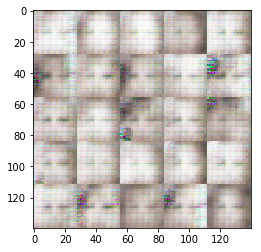

Epoch:  0 Batch:  1510 Discriminator_Loss:  0.610606 Generator_Loss:  0.984147
Epoch:  0 Batch:  1520 Discriminator_Loss:  3.91923 Generator_Loss:  4.79628
Epoch:  0 Batch:  1530 Discriminator_Loss:  0.142724 Generator_Loss:  2.5863
Epoch:  0 Batch:  1540 Discriminator_Loss:  0.114594 Generator_Loss:  2.59435
Epoch:  0 Batch:  1550 Discriminator_Loss:  0.153539 Generator_Loss:  2.10548
Epoch:  0 Batch:  1560 Discriminator_Loss:  0.0469627 Generator_Loss:  3.39901
Epoch:  0 Batch:  1570 Discriminator_Loss:  0.127125 Generator_Loss:  2.37554
Epoch:  0 Batch:  1580 Discriminator_Loss:  0.0812542 Generator_Loss:  4.05045
Epoch:  0 Batch:  1590 Discriminator_Loss:  0.0228538 Generator_Loss:  5.39509
Epoch:  0 Batch:  1600 Discriminator_Loss:  0.0353023 Generator_Loss:  3.82862


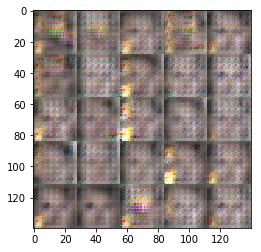

Epoch:  0 Batch:  1610 Discriminator_Loss:  0.0287838 Generator_Loss:  3.72935
Epoch:  0 Batch:  1620 Discriminator_Loss:  0.0110669 Generator_Loss:  6.2509
Epoch:  0 Batch:  1630 Discriminator_Loss:  0.0194495 Generator_Loss:  4.47085
Epoch:  0 Batch:  1640 Discriminator_Loss:  0.00450086 Generator_Loss:  5.96261
Epoch:  0 Batch:  1650 Discriminator_Loss:  0.053835 Generator_Loss:  3.32421
Epoch:  0 Batch:  1660 Discriminator_Loss:  0.00399416 Generator_Loss:  6.56133
Epoch:  0 Batch:  1670 Discriminator_Loss:  0.00804464 Generator_Loss:  5.42477
Epoch:  0 Batch:  1680 Discriminator_Loss:  0.0173277 Generator_Loss:  4.45514
Epoch:  0 Batch:  1690 Discriminator_Loss:  0.017999 Generator_Loss:  4.92002
Epoch:  0 Batch:  1700 Discriminator_Loss:  0.00326801 Generator_Loss:  6.38005


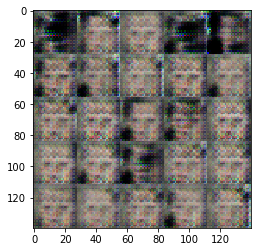

Epoch:  0 Batch:  1710 Discriminator_Loss:  0.00352655 Generator_Loss:  7.01352
Epoch:  0 Batch:  1720 Discriminator_Loss:  5.42955 Generator_Loss:  0.0289404
Epoch:  0 Batch:  1730 Discriminator_Loss:  0.733392 Generator_Loss:  1.27675
Epoch:  0 Batch:  1740 Discriminator_Loss:  2.26406 Generator_Loss:  0.567647
Epoch:  0 Batch:  1750 Discriminator_Loss:  1.14889 Generator_Loss:  0.831702
Epoch:  0 Batch:  1760 Discriminator_Loss:  1.11 Generator_Loss:  0.55863
Epoch:  0 Batch:  1770 Discriminator_Loss:  1.0143 Generator_Loss:  0.798047
Epoch:  0 Batch:  1780 Discriminator_Loss:  1.23742 Generator_Loss:  2.23436
Epoch:  0 Batch:  1790 Discriminator_Loss:  2.71164 Generator_Loss:  4.68538
Epoch:  0 Batch:  1800 Discriminator_Loss:  2.55501 Generator_Loss:  4.7397


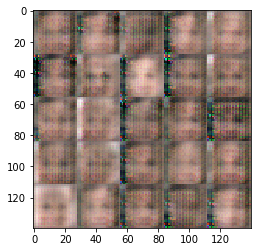

Epoch:  0 Batch:  1810 Discriminator_Loss:  0.901659 Generator_Loss:  1.08991
Epoch:  0 Batch:  1820 Discriminator_Loss:  1.56476 Generator_Loss:  0.31608
Epoch:  0 Batch:  1830 Discriminator_Loss:  1.423 Generator_Loss:  0.519045
Epoch:  0 Batch:  1840 Discriminator_Loss:  1.97673 Generator_Loss:  0.186991
Epoch:  0 Batch:  1850 Discriminator_Loss:  1.74291 Generator_Loss:  0.292031
Epoch:  0 Batch:  1860 Discriminator_Loss:  0.934876 Generator_Loss:  0.872439
Epoch:  0 Batch:  1870 Discriminator_Loss:  0.956301 Generator_Loss:  1.14761
Epoch:  0 Batch:  1880 Discriminator_Loss:  1.15058 Generator_Loss:  1.08924
Epoch:  0 Batch:  1890 Discriminator_Loss:  1.2232 Generator_Loss:  0.71309
Epoch:  0 Batch:  1900 Discriminator_Loss:  0.991045 Generator_Loss:  0.666892


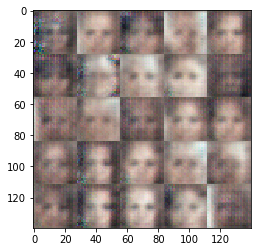

Epoch:  0 Batch:  1910 Discriminator_Loss:  0.946214 Generator_Loss:  2.12069
Epoch:  0 Batch:  1920 Discriminator_Loss:  1.81068 Generator_Loss:  1.87844
Epoch:  0 Batch:  1930 Discriminator_Loss:  1.30895 Generator_Loss:  1.47366
Epoch:  0 Batch:  1940 Discriminator_Loss:  1.17372 Generator_Loss:  0.728598
Epoch:  0 Batch:  1950 Discriminator_Loss:  1.23679 Generator_Loss:  0.473505
Epoch:  0 Batch:  1960 Discriminator_Loss:  1.01838 Generator_Loss:  0.993212
Epoch:  0 Batch:  1970 Discriminator_Loss:  1.02989 Generator_Loss:  1.08627
Epoch:  0 Batch:  1980 Discriminator_Loss:  1.49737 Generator_Loss:  3.84578
Epoch:  0 Batch:  1990 Discriminator_Loss:  0.641251 Generator_Loss:  1.84054
Epoch:  0 Batch:  2000 Discriminator_Loss:  1.3184 Generator_Loss:  0.62149


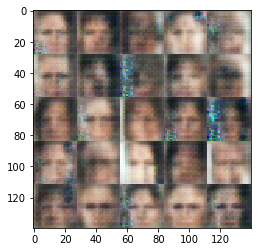

Epoch:  0 Batch:  2010 Discriminator_Loss:  2.55586 Generator_Loss:  3.39989
Epoch:  0 Batch:  2020 Discriminator_Loss:  0.93947 Generator_Loss:  0.669644
Epoch:  0 Batch:  2030 Discriminator_Loss:  2.65042 Generator_Loss:  5.63544
Epoch:  0 Batch:  2040 Discriminator_Loss:  1.32821 Generator_Loss:  0.407725
Epoch:  0 Batch:  2050 Discriminator_Loss:  0.938779 Generator_Loss:  0.846581
Epoch:  0 Batch:  2060 Discriminator_Loss:  0.438456 Generator_Loss:  1.29993
Epoch:  0 Batch:  2070 Discriminator_Loss:  0.90193 Generator_Loss:  0.784827
Epoch:  0 Batch:  2080 Discriminator_Loss:  0.153506 Generator_Loss:  2.31037
Epoch:  0 Batch:  2090 Discriminator_Loss:  0.613709 Generator_Loss:  0.915217
Epoch:  0 Batch:  2100 Discriminator_Loss:  1.33189 Generator_Loss:  0.780837


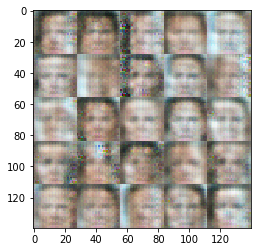

Epoch:  0 Batch:  2110 Discriminator_Loss:  1.57022 Generator_Loss:  0.269293
Epoch:  0 Batch:  2120 Discriminator_Loss:  1.12435 Generator_Loss:  0.978293
Epoch:  0 Batch:  2130 Discriminator_Loss:  0.650079 Generator_Loss:  1.41308
Epoch:  0 Batch:  2140 Discriminator_Loss:  0.168951 Generator_Loss:  2.59913
Epoch:  0 Batch:  2150 Discriminator_Loss:  1.76798 Generator_Loss:  0.434511
Epoch:  0 Batch:  2160 Discriminator_Loss:  0.266655 Generator_Loss:  1.8349
Epoch:  0 Batch:  2170 Discriminator_Loss:  0.630701 Generator_Loss:  0.896973
Epoch:  0 Batch:  2180 Discriminator_Loss:  2.46224 Generator_Loss:  0.103584
Epoch:  0 Batch:  2190 Discriminator_Loss:  1.456 Generator_Loss:  0.659104
Epoch:  0 Batch:  2200 Discriminator_Loss:  1.18929 Generator_Loss:  1.68808


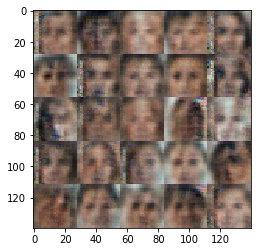

Epoch:  0 Batch:  2210 Discriminator_Loss:  0.402892 Generator_Loss:  1.91204
Epoch:  0 Batch:  2220 Discriminator_Loss:  0.689009 Generator_Loss:  0.800365
Epoch:  0 Batch:  2230 Discriminator_Loss:  0.903727 Generator_Loss:  0.642227
Epoch:  0 Batch:  2240 Discriminator_Loss:  1.21421 Generator_Loss:  0.701101
Epoch:  0 Batch:  2250 Discriminator_Loss:  1.5379 Generator_Loss:  0.584861
Epoch:  0 Batch:  2260 Discriminator_Loss:  1.58086 Generator_Loss:  0.70496
Epoch:  0 Batch:  2270 Discriminator_Loss:  0.529533 Generator_Loss:  2.32383
Epoch:  0 Batch:  2280 Discriminator_Loss:  1.54773 Generator_Loss:  0.340393
Epoch:  0 Batch:  2290 Discriminator_Loss:  1.17967 Generator_Loss:  0.997261
Epoch:  0 Batch:  2300 Discriminator_Loss:  1.32929 Generator_Loss:  2.12224


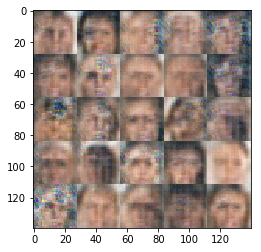

Epoch:  0 Batch:  2310 Discriminator_Loss:  0.53475 Generator_Loss:  1.49513
Epoch:  0 Batch:  2320 Discriminator_Loss:  2.03414 Generator_Loss:  0.160073
Epoch:  0 Batch:  2330 Discriminator_Loss:  0.408793 Generator_Loss:  1.25682


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.01


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.